# Sprint アンサンブル学習

## Sprintの目的
アンサンブル学習について理解する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split

In [2]:
def scratch_train_test_split(X, y, train_size=0.8,):
    """
    検証用データを分割する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, )
      正解値
    train_size : float (0<train_size<1)
      何割をtrainとするか指定

    Returns
    ----------
    X_train : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    X_test : 次の形のndarray, shape (n_samples, n_features)
      検証データ
    y_train : 次の形のndarray, shape (n_samples, )
      学習データの正解値
    y_test : 次の形のndarray, shape (n_samples, )
      検証データの正解値
    """
    n_samples = len(X)
    idx = np.zeros(n_samples)
    train_size =  int(n_samples*train_size)
    train_idx = np.random.choice(np.arange(n_samples), train_size, replace=False)
    idx[train_idx] = 1
    
    X_train ,X_test = X[idx==1], X[idx==0]
    y_train ,y_test = y[idx==1], y[idx==0]
    
    return X_train, X_test, y_train, y_test

In [3]:
data0 = pd.read_csv("../housing_train.csv")

In [4]:
data_X = data0[["GrLivArea", "YearBuilt"]]
data_y = data0["SalePrice"]
display(data_X.head(3))
display(data_y.head(3))

,GrLivArea,YearBuilt
0,1710,2003
1,1262,1976
2,1786,2001


0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = scratch_train_test_split(data_X, data_y, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 2), (292, 2), (1168,), (292,))

In [6]:
reg_linear_regression = LinearRegression().fit(X_train, y_train)
y_pred_linear_regression = reg_linear_regression.predict(X_test)
print("score =", reg_linear_regression.score(X_test, y_test))

score = 0.7079614828360515


In [7]:
reg_svr_linear = SVR(kernel="linear").fit(X_train, y_train)
y_pred_svr_linear = reg_svr_linear.predict(X_test)
print("score =", reg_svr_linear.score(X_test, y_test))

score = 0.6780426521255516


In [8]:
reg_decision_tree = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
y_pred_decision_tree = reg_decision_tree.predict(X_test)
print("score =", reg_decision_tree.score(X_test, y_test))

score = 0.6250773082211439


## 【問題1】ブレンディングのスクラッチ実装

In [9]:
def mse(y_pred, y_true):
    return np.average((y_pred - y_true)**2)

In [10]:
def scratch_blending(*y_preds, ratio=None, y_true, print_mse=[]):
    if ratio is None:
        return np.average(y_preds, axis=0)
    y_pred_blending = ratio@y_preds / np.sum(ratio)
    
    if print_mse:
        for i in range(len(y_preds)):
            print("MSE(", print_mse[i], ") = ", mse(y_preds[i], y_true), sep="")
        print("MSE(blend) = ", mse(y_pred_blending, y_true), sep="")
        
    return y_pred_blending

In [11]:
ratio = np.array([3, 3, 1])
y_pred_blending = scratch_blending(y_pred_linear_regression, y_pred_svr_linear, y_pred_decision_tree, ratio=ratio, y_true=y_test, print_mse=["lr", "svr", "tree"])

MSE(lr) = 2164300655.425956
MSE(svr) = 2386029438.1397824
MSE(tree) = 2778556183.037671
MSE(blend) = 2001433593.193562


In [12]:
ratio = np.array([1, 1])
y_pred_blending = scratch_blending(y_pred_linear_regression, y_pred_svr_linear, ratio=ratio, y_true=y_test, print_mse=["lr", "svr"])

MSE(lr) = 2164300655.425956
MSE(svr) = 2386029438.1397824
MSE(blend) = 2252280283.767199


In [13]:
ratio = np.array([5, 1])
y_pred_blending = scratch_blending(y_pred_linear_regression, y_pred_decision_tree, ratio=ratio, y_true=y_test, print_mse=["lr", "tree"])

MSE(lr) = 2164300655.425956
MSE(tree) = 2778556183.037671
MSE(blend) = 1910560472.4760082


In [14]:
ratio = np.array([3, 1])
y_pred_blending = scratch_blending(y_pred_svr_linear, y_pred_decision_tree, ratio=ratio, y_true=y_test, print_mse=["svr", "tree"])

MSE(svr) = 2386029438.1397824
MSE(tree) = 2778556183.037671
MSE(blend) = 1957872383.1158473


## 【問題2】バギングのスクラッチ実装

In [15]:
def scratch_bagging(X_train, X_test, y_train, y_test, model, n):
    y_pred_ndarray = np.empty((n, y_test.shape[0]))
    for i in range(n):
        X_train_brs, _, y_train_brs, _ = train_test_split(X_train, y_train, test_size=1-2/(n+2), shuffle=True)
        _reg = model().fit(X_train_brs, y_train_brs)
        y_pred_ndarray[i] = _reg.predict(X_test)
    y_pred_bagging = np.average(y_pred_ndarray, axis=0)
    
    return y_pred_bagging

In [19]:
y_pred_bagging = scratch_bagging(X_train, X_test, y_train, y_test, DecisionTreeRegressor, n=4)

print("MSE(lr) = ", mse(y_pred_linear_regression, y_test), sep="")
print("MSE(bag) = ", mse(y_pred_bagging, y_test), sep="")

MSE(lr) = 2164300655.425956
MSE(bag) = 1976536974.4743152


## 【問題3】スタッキングのスクラッチ実装

In [17]:
class ScratchStacking():
    """
    ステージ0とステージ1のみのスタッキング
    """
    def __init__(self):
        self.k0 = 0
        self.m0 = 0
        self.list_models = None
    
    def fit(self, X, y, k0, m0, *models, model_z):
        self.k0 = k0
        self.m0 = m0
        n_split_samples = int(len(X)/k0)+1
        idx = np.arange(X.shape[0])
        idx_split = [idx[i*n_split_samples:(i+1)*n_split_samples] for i in range(k0)]

        y_pred_ndarray0 = np.empty((X.shape[0], m0))
        list_models = []
        for i in range(m0):
            model = models[i]
            y_pred_ndarray = np.empty(X.shape[0])
            _list_model = []
            for j in range(k0):
                idx_bl_j = np.full(idx.shape, False)
                idx_bl_j[idx_split[j]] = True
                idx_bl_j_c = idx_bl_j==np.full(idx.shape, False)  # idx_bl_j_c = ~idx_bl_j
                _reg = model().fit(X[idx_bl_j_c], y[idx_bl_j_c])
                y_pred_ndarray[idx_split[j]] = _reg.predict(X[idx_bl_j])
                _list_model.append(_reg)
            y_pred_ndarray0[:, i] = y_pred_ndarray
            list_models.append(_list_model)
        self.list_models = [list_models]
        model0 = model_z().fit(y_pred_ndarray0, y)
        self.list_models.append(model0)
    
    def predict(self, X):
        y_pred_ndarray0 = np.empty((X.shape[0], self.m0, self.k0))
        
        for i in range(self.m0):
            for j in range(self.k0):
                y_pred_ndarray0[:, i, j] = self.list_models[0][i][j].predict(X)
        y_pred_ndarray1 = np.average(y_pred_ndarray0, axis=2)
        
        y_pred = self.list_models[1].predict(y_pred_ndarray1)
        
        return y_pred

In [29]:
scratch_stacking = ScratchStacking()
scratch_stacking.fit(X_train, y_train, 3, 2, LinearRegression, DecisionTreeRegressor, model_z=LinearRegression)
y_pred_stacking = scratch_stacking.predict(X_test)
print("MSE(stack) = ", mse(y_pred_stacking, y_test), sep="")

MSE(stack) = 1798258830.3234181


### 分割数（k0）を変えてみる

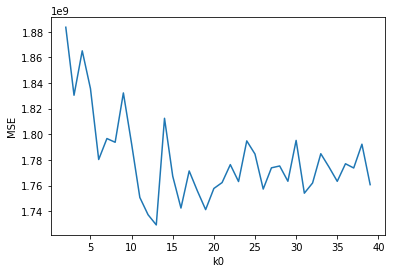

In [23]:
list_mse = []
list_x = list(range(2, 40))
for i in list_x:
    scratch_stacking.fit(X_train, y_train, i, 2, LinearRegression, DecisionTreeRegressor, model_z=LinearRegression)
    _y_pred_stacking = scratch_stacking.predict(X_test)
    list_mse.append(mse(_y_pred_stacking, y_test))
    #print("MSE(", "", ") = ", mse(y_pred, y_test), sep="")

plt.plot(list_x, list_mse)
plt.ylabel("MSE")
plt.xlabel("k0")
plt.show()